In [154]:
import time

from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

In [155]:
SCALE = 10

## Load "Sčítání lidí"

In [225]:
dfs = pd.read_excel("./data/sldb2021_pv_vek_pohlavi.xlsx").set_index("věk")

ages = []
genders = []

for n, row in tqdm(dfs.iterrows()):
    for m in range(row["muži"] // SCALE):
        genders.append("M")
        ages.append(n)

    for f in range(row["ženy"] // SCALE):
        genders.append("F")
        ages.append(n)

persons = pd.DataFrame({"vek": ages, "pohlavi": genders, "davek_v_tele": 0})

101it [00:00, 434.10it/s]


## Load deaths

In [226]:
dfd = pd.read_csv("data/DEMOMIGR_2005_2021_komplet.csv")
# We do not want break out by region
dfd = dfd[dfd["uzemi"] == "CZ"].drop(columns=["uzemi"])

# We do not want other years
dfd = dfd[dfd["tyden"].str.split("-").str[0] == "2021"]

# We do not want summaries "Celkem"
dfd = dfd[dfd["pohlavi"] != "T"]

# Converting and "normalizing"
dfd["tyden"] = pd.to_datetime(dfd["tyden"] + '0', format="%Y-W%W%w")
# dfd["vek"] = dfd["vek"].str.split("T").str[0].str.lstrip("Y").replace("_GE90", 90).astype(int)
dfd['vekova_skupina'] = (
    dfd['vek']
    .str.replace("_GE90", '90-120')
    .str.replace('Y', '')
    .str.replace('T', '-')
)

dfd = dfd.rename(columns={"tyden": "datum", 'hodnota': 'pocet_umrti'})

df_deaths = dfd.drop(columns='vek').set_index(['datum', 'pohlavi'])

## Load vaccinations

In [227]:
dfo = pd.read_csv("data/ockovani-demografie.csv")

# Runtime optimization
dfo = dfo.groupby(["datum", "vekova_skupina", "pohlavi", 'poradi_davky']).sum().reset_index()

# Converting and "normalizing"
dfo["datum"] = pd.to_datetime(dfo["datum"], format="%Y-%m-%d")
dfo["pohlavi"] = dfo["pohlavi"].replace("Z", "F")
dfo["vekova_skupina"] = dfo["vekova_skupina"].replace("80+", "80-100")
# dfo = dfo.rename(columns={"pocet_davek": "hodnota"})

# Runtime optimization
dfo = dfo.groupby([pd.Grouper(key='datum', freq='W-SUN'), "pohlavi", "vekova_skupina", "poradi_davky"]).sum().reset_index()

df_vaccination = dfo.set_index(['datum', 'pohlavi'])
df_vaccination["pocet_davek"] = (df_vaccination["pocet_davek"] / 10).round().astype(int)

## Quick look

In [159]:
persons

,vek,pohlavi,davek_v_tele
0,0,M,0
1,0,M,0
2,0,M,0
3,0,M,0
4,0,M,0
...,...,...,...
1052325,100,F,0
1052326,100,F,0
1052327,100,F,0
1052328,100,F,0


In [160]:
df_deaths

pocet_umrti vekova_skupina
datum      pohlavi                            
2021-01-10 M                  1            0-4
           F                  3            0-4
           M                  0            5-9
           F                  1            5-9
           M                  0          10-14
...                         ...            ...
2021-12-26 F                256          80-84
           M                144          85-89
           F                241          85-89
           M                122         90-120
           F                316         90-120

[1938 rows x 2 columns]

In [183]:
df_vaccination

vekova_skupina  poradi_davky  pocet_davek
datum      pohlavi                                          
2020-12-27 F                18-24             1            2
           F                25-29             1            8
           F                30-34             1            7
           F                35-39             1            8
           F                40-44             1           12
...                           ...           ...          ...
2022-10-02 M                75-79             1            0
           M                75-79             3            0
           M                75-79             4            8
           M               80-100             3            0
           M               80-100             4            6

[7621 rows x 3 columns]

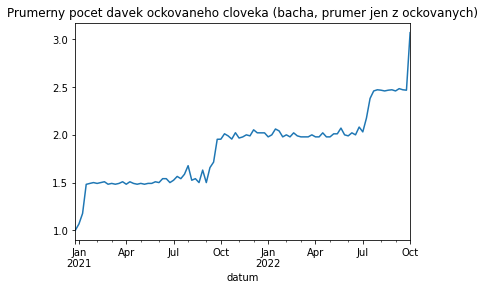

In [185]:
df_vaccination.groupby(df_vaccination.index.get_level_values('datum'))['poradi_davky'].mean().plot()
plt.title('Prumerny pocet davek ockovaneho cloveka (bacha, prumer jen z ockovanych)');

In [11]:
# df_vaccination[df_vaccination['vekova_skupina'] == '80-100'].xs('M', level=1)#.plot(y='pocet_davek')

## Model
- Pro zrychleni lze pouzivat .itertuples misto .iterrows, viz:
  - https://medium.com/swlh/why-pandas-itertuples-is-faster-than-iterrows-and-how-to-make-it-even-faster-bc50c0edd30d
- np.random.choice ma tu vyhodu, ze lze vyuzit parameter vah `p` pro pridani korelace vakcinace s umrtimi.

In [165]:
weeks = sorted(df_deaths.index.get_level_values('datum').unique())

In [167]:
len(weeks)

51

In [180]:
DEBUG = False

In [228]:
counts = []
counts_marked = []

for k, week in tqdm(enumerate(weeks)):
    # -------- Mark newly vaccinated --------
    # Dva radky nize jsou super sofistikovany (a elegantni) pandas trik
    #  .groupby('poradi_davky') rozdeli tyden na casti podle sloupce `poradi_davky`
    #  nasledne iteruji pres vsechny 1. vakciny vyockovane v danem tydnu, vsechny 2., ...
    grouped_vaccination_week = df_vaccination.loc[week].groupby('poradi_davky')
    for davka, vacc_week in grouped_vaccination_week:
        print(f'Zpracovavam {davka}. davku...')
        # print(vacc_week)
        # print('*'*5)

        for row in vacc_week.itertuples():
            if row.pocet_davek == 0:
                continue
            age = tuple(int(a) for a in row.vekova_skupina.split("-"))
            
            # Vyberu lidi s danym pohlavim, v danem vekovem intervalu
            #  a se spravnym poctem davek (tj. ockovana davka - 1).
            cohort = persons[
                (persons["pohlavi"] == row.Index) &
                (persons["vek"] >= age[0]) &
                (persons["vek"] <= age[1]) &
                (persons["davek_v_tele"] == davka-1)
            ]

            if row.pocet_davek > len(cohort):
                a = persons[
                    (persons["pohlavi"] == row.Index) &
                    (persons["vek"] >= age[0]) &
                    (persons["vek"] <= age[1])
                ]

                print(a.groupby("davek_v_tele").count())
                print('Neco je divne, mam ockovat vice lidi nez je v dane skupine.')
                print(f"**** Je tyden {week:%Y-%m-%d} a ja ve vekove skupine {row.vekova_skupina:>6} vyberu"
                      f"{row.pocet_davek:>7,d} ockovanych z {len(cohort):>7,d} moznych")
                continue

            # Nahodne vyberu kdo bude v dane skupine vakcinovany.
            sampled_indices = cohort.sample(n=row.pocet_davek, replace=False).index
            persons.loc[sampled_indices, "davek_v_tele"] += 1

            if DEBUG:
                # Vypisu co se deje. Model ma dost pohyblivych casti.
                print(f"Je {week:%Y-%m-%d} a ve věkové skupině {row.vekova_skupina:>6} vyberu"
                      f"{row.pocet_davek:>7,d} lidí s {davka-1} dávkami z {len(cohort):>7,d} možných, "
                      f"které tento týden naočkuji.")

    # -------- Remove dead people --------
    for row in df_deaths.loc[week].itertuples():
        if row.pocet_umrti > 0:
            # TODO toto udělat jako preprocessing, zbytečně se to počítá pořád
            age = tuple(int(a) for a in row.vekova_skupina.split("-"))

            cohort = persons[
                (persons["pohlavi"] == row.Index[1]) &
                (persons["vek"] >= age[0]) &
                (persons["vek"] <= age[1])
            ]
            persons = persons[~persons.index.isin(cohort.sample(n=row.pocet_umrti).index)]

            if DEBUG:
                # Vypisu co se deje. Model ma dost pohyblivych casti.
                print(f"Je {week:%Y-%m-%d} a ve věkové skupině {row.vekova_skupina:>6} umírá"
                      f"{row.pocet_umrti:>7,d} lidí z {len(cohort):>7,d} možných")

    counts.append(len(persons))
    counts_marked.append((persons["davek_v_tele"] >= 1).sum())

    # Sanity check
    if len(counts) > 1 and counts[-1] == counts[-2]:
        print("Error, nikdo nezemřel!")

    # TODO: Odstranit, jen pro debug.
    if k >= 5:
        break

0it [00:00, ?it/s]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


1it [00:03,  3.55s/it]

2.210099935531616
Zpracovavam 1. davku...
Zpracovavam 2. davku...


2it [00:07,  3.69s/it]

2.0949649810791016
Zpracovavam 1. davku...
Zpracovavam 2. davku...


3it [00:11,  3.87s/it]

2.2398531436920166
Zpracovavam 1. davku...
Zpracovavam 2. davku...


4it [00:15,  3.94s/it]

2.1814651489257812
Zpracovavam 1. davku...
Zpracovavam 2. davku...


5it [00:19,  3.95s/it]

2.150622844696045
Zpracovavam 1. davku...
Zpracovavam 2. davku...


5it [00:23,  4.69s/it]

2.085198163986206


## Visualizations
- TODO

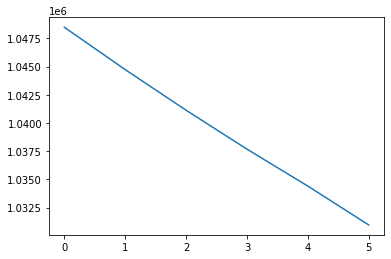

In [232]:
plt.plot(np.diff(counts));

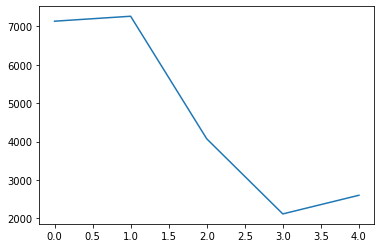

In [233]:
plt.plot(np.diff(counts_marked));

In [237]:
%%time
df_deaths.loc[week]

CPU times: user 430 µs, sys: 302 µs, total: 732 µs
Wall time: 720 µs


,pocet_umrti,vekova_skupina
pohlavi,,
M,5,0-4
F,3,0-4
M,0,5-9
F,0,5-9
M,0,10-14
F,2,10-14
M,2,15-19
F,3,15-19
M,3,20-24


In [238]:
%%time
df_deaths[df_deaths.index.get_level_values("datum") == week]

CPU times: user 753 µs, sys: 873 µs, total: 1.63 ms
Wall time: 1.06 ms


pocet_umrti vekova_skupina
datum      pohlavi                            
2021-02-14 M                  5            0-4
           F                  3            0-4
           M                  0            5-9
           F                  0            5-9
           M                  0          10-14
           F                  2          10-14
           M                  2          15-19
           F                  3          15-19
           M                  3          20-24
           F                  0          20-24
           M                  3          25-29
           F                  5          25-29
           M                  4          30-34
           F                  4          30-34
           M                 17          35-39
           F                  6          35-39
           M                 25          40-44
           F                 12          40-44
           M                 35          45-49
           F                 17          45-49
           M                 56          50-54
           F                 18          50-54
           M                 78          55-59
           F                 35          55-59
           M                145          60-64
           F                 54          60-64
           M                228          65-69
           F                109          65-69
           M                331          70-74
           F                209          70-74
           M                332          75-79
           F                224          75-79
           M                245          80-84
           F                251          80-84
           M                208          85-89
           F                342          85-89
           M                126         90-120
           F                306         90-120